In [52]:
# import libraries
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython import display
from concurrent.futures import ProcessPoolExecutor, as_completed

display.set_matplotlib_formats('svg')


plt.style.use('dark_background')

/tmp/ipykernel_1237/2656154680.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [53]:
def customModel(x, y, non_linear=True, hidden_layer=1, num_epochs=800):
    # Build a custom model

    if non_linear is True:
        customNN = nn.Sequential(
            nn.Linear(1, hidden_layer),    # Input layer
            nn.Sigmoid(),        # Activation function
            nn.Linear(hidden_layer, 1)     # Output layer
        )
    else:
        customNN = nn.Sequential(
            nn.Linear(1, hidden_layer),    # Input layer
            nn.Linear(hidden_layer, 1)     # Output layer
        )

    # Custom loss and optimizer
    customLoss = nn.MSELoss()
    customOptimizer = torch.optim.SGD(customNN.parameters(), lr=0.01)

    # Train the custom model
    custom_losses = torch.zeros(num_epochs)

    for epoch in range(num_epochs):
        # Forward pass
        y_pred = customNN(x)

        # Calculate loss
        loss = customLoss(y_pred, y)
        custom_losses[epoch] = loss

        # Backpropagation
        customOptimizer.zero_grad()
        loss.backward()
        customOptimizer.step()

    # Predictions
    predictions = customNN(x)

    return predictions, custom_losses

def generateCustomData(m):
    N = 60
    x = torch.randn(N, 1)
    y = m * x + torch.randn(N, 1) / 1.5
    return x, y


In [54]:
# Create a custom dataset
x_custom, y_custom = generateCustomData(0.7)

# Train the custom model
y_custom_predictions, custom_losses = customModel(x_custom, y_custom)
y_custom_predictions = y_custom_predictions.detach()

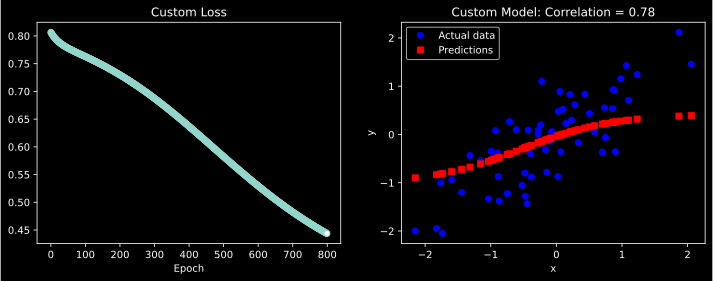

In [55]:
# Plot the custom model results
fig_custom, ax_custom = plt.subplots(1, 2, figsize=(12, 4))

ax_custom[0].plot(custom_losses.detach(), 'o', markerfacecolor='w', linewidth=0.1)
ax_custom[0].set_xlabel('Epoch')
ax_custom[0].set_title('Custom Loss')

ax_custom[1].plot(x_custom, y_custom, 'bo', label='Actual data')
ax_custom[1].plot(x_custom, y_custom_predictions, 'rs', label='Predictions')
ax_custom[1].set_xlabel('x')
ax_custom[1].set_ylabel('y')
ax_custom[1].set_title(f'Custom Model: Correlation = {np.corrcoef(y_custom.T, y_custom_predictions.T)[0, 1]:.2f}')
ax_custom[1].legend()

plt.show()


In [30]:
# Define the function to run a single experiment
def run_experiment(param_index, experiment_index):
    x_custom, y_custom = generateCustomData(custom_parameters[param_index])
    y_custom_predictions, custom_losses = customModel(x_custom, y_custom)
    y_custom_predictions = y_custom_predictions.detach().numpy()
    custom_losses = custom_losses.detach().numpy()  # Detach and convert to NumPy

    # Calculate the loss and correlation for this experiment
    final_loss = custom_losses[-1]
    correlation = np.corrcoef(y_custom.T, y_custom_predictions.T)[0, 1]

    return param_index, experiment_index, final_loss, correlation

In [31]:
# Simulate different parameters
custom_parameters = np.linspace(-1, 1, 21)
num_experiments = 100
custom_results = np.zeros((len(custom_parameters), num_experiments, 2))

# Parallelizing with ProcessPoolExecutor
with ProcessPoolExecutor() as executor:
    futures = []

    for param_index in range(len(custom_parameters)):
        for experiment_index in range(num_experiments):
            # Submit each experiment to the executor
            futures.append(executor.submit(run_experiment, param_index, experiment_index))

    # Collecting results as they complete
    for future in as_completed(futures):
        param_index, experiment_index, final_loss, correlation = future.result()
        custom_results[param_index, experiment_index, 0] = final_loss
        custom_results[param_index, experiment_index, 1] = correlation

# Handle NaN values
custom_results[np.isnan(custom_results)] = 0

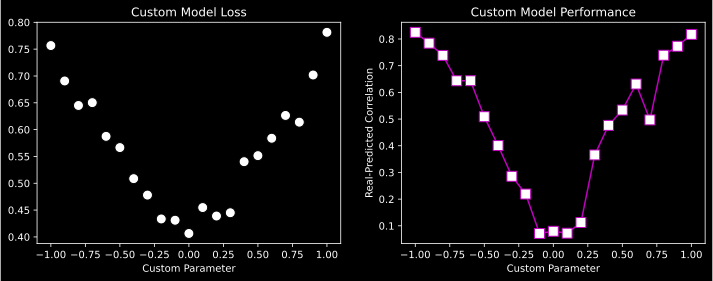

In [32]:
# Plot the simulation results
fig_sim, ax_sim = plt.subplots(1, 2, figsize=(12, 4))

ax_sim[0].plot(custom_parameters, np.mean(custom_results[:, :, 0], axis=1), 'ko-', markerfacecolor='w', markersize=10)
ax_sim[0].set_xlabel('Custom Parameter')
ax_sim[0].set_title('Custom Model Loss')

ax_sim[1].plot(custom_parameters, np.mean(custom_results[:, :, 1], axis=1), 'ms-', markerfacecolor='w', markersize=10)
ax_sim[1].set_xlabel('Custom Parameter')
ax_sim[1].set_ylabel('Real-Predicted Correlation')
ax_sim[1].set_title('Custom Model Performance')

plt.show()


In [ ]:
# Visualize custom data with a different parameter
custom_param = 0.0

x_custom, y_custom = generateCustomData(custom_param)

plt.title(f'Custom Parameter = {custom_param}')
plt.plot(x_custom, y_custom, 'o')
plt.ylim([-4, 4])
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [56]:
custom_epoches = np.arange(100, 2000, 100, dtype='int')
num_experiments = 50
custom_results = np.zeros((len(custom_epoches), num_experiments, 2))

for param_index in range(len(custom_epoches)):
    for experiment_index in range(num_experiments):
        # Generate custom data and train the model
        x_custom, y_custom = generateCustomData(0.7) # Use 0.7
        y_custom_predictions, custom_losses = customModel(x_custom, y_custom, num_epochs=custom_epoches[param_index])
        y_custom_predictions = y_custom_predictions.detach()
    
        # Store the final loss and correlation
        custom_results[param_index, experiment_index, 0] = custom_losses[-1]
        custom_results[param_index, experiment_index, 1] = np.corrcoef(y_custom.T, y_custom_predictions.T)[0, 1]

custom_results[np.isnan(custom_results)] = 0

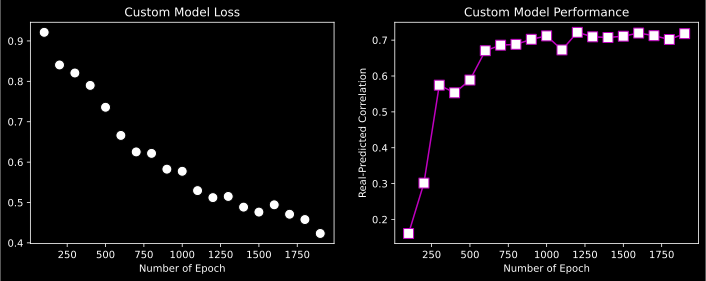

In [57]:
# Plot the simulation results
fig_sim, ax_sim = plt.subplots(1, 2, figsize=(12, 4))

ax_sim[0].plot(custom_epoches, np.mean(custom_results[:, :, 0], axis=1), 'ko-', markerfacecolor='w', markersize=10)
ax_sim[0].set_xlabel('Number of Epoch')
ax_sim[0].set_title('Custom Model Loss')

ax_sim[1].plot(custom_epoches, np.mean(custom_results[:, :, 1], axis=1), 'ms-', markerfacecolor='w', markersize=10)
ax_sim[1].set_xlabel('Number of Epoch')
ax_sim[1].set_ylabel('Real-Predicted Correlation')
ax_sim[1].set_title('Custom Model Performance')

plt.show()